In [1]:
import os
import sys

# sys.path.append('/mnt/0A2AAC152AABFBB7/CGE/luxgiant-dstream')
sys.path.append('/home/luis//CGE/luxgiant-dstream')

from luxgiant_dstream import plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# home path
#df_gwas_top = pd.read_csv('/mnt/0A2AAC152AABFBB7/data/testMiamiPlot/luxgiant_data_hg19.txt', sep='\t')
#df_gwas_bottom = pd.read_csv('/mnt/0A2AAC152AABFBB7/data/testMiamiPlot/known_results_hg19.txt', sep='\t')

# work path
df_gwas_top = pd.read_csv('/home/luis/data/MiamiPlots/luxgiant_data_hg19.txt', sep='\t')
df_gwas_bottom = pd.read_csv('/home/luis/data/MiamiPlots/known_results_hg19.txt', sep='\t')

In [3]:
def prepare_data(data_top:pd.DataFrame, data_bottom:pd.DataFrame)->pd.DataFrame:

    data_top['split_by'] = 'top'
    data_bottom['split_by'] = 'bottom'

    joint = pd.concat([data_top, data_bottom], axis=0)

    return joint

def compute_relative_pos(data, chr_col='chr', pos_col='pos', p_col='p'):

    # Group by chromosome and compute chromosome size
    chr_grouped = data.groupby(chr_col).agg(chrlength=(pos_col, 'max')).reset_index()

    # Calculate cumulative chromosome length
    chr_grouped['cumulativechrlength'] = chr_grouped['chrlength'].cumsum() - chr_grouped['chrlength']

    # Merge cumulative chromosome length back to the original data
    data = pd.merge(data, chr_grouped[[chr_col, 'cumulativechrlength']], on=chr_col)

    # Sort by chromosome and position
    data = data.sort_values(by=[chr_col, pos_col])

    # Add the relative position of the probe/snp
    data['rel_pos'] = data[pos_col] + data['cumulativechrlength']

    # Drop cumulative chromosome length column
    data = data.drop(columns=['cumulativechrlength'])

    data['log10p']= -np.log10(data[p_col])

    return data

def find_chromosomes_center(data, chr_col='CHR', chr_pos_col='rel_pos'):

    chromosomes = data[chr_col].unique()

    axis_center = pd.DataFrame(columns=['CHR', 'center'])

    for i, chrom in enumerate(chromosomes):

        temp = data[data[chr_col] == chrom].reset_index(drop=True)

        axis_center.loc[i, 'CHR'] = chrom
        axis_center.loc[i, 'center'] = np.round((temp[chr_pos_col].max()+temp[chr_pos_col].min())/2,0)

    return axis_center

def process_miami_data(data_top:pd.DataFrame, data_bottom)->dict:

    data = prepare_data(data_top, data_bottom)

    data = compute_relative_pos(data, chr_col='CHR', pos_col='bp', p_col='p')

    axis_center = find_chromosomes_center(data)

    maxp = np.ceil(data['log10p'].max(skipna=True))

    df_top = data[data['split_by'] == 'top']
    df_bottom = data[data['split_by'] == 'bottom']

    miami_data = {
        'upper': df_top,
        'lower': df_bottom,
        'axis': axis_center,
        'maxp': maxp
    }

    return miami_data


In [4]:
#all_data = prepare_data(df_gwas_top, df_gwas_bottom)
#all_data.to_csv('/home/luis/data/MiamiPlots/all_data.csv', index=False)
#all_data

In [5]:
m_data = process_miami_data(df_gwas_top, df_gwas_bottom)

In [6]:
m_data['upper']

,CHR,bp,SNP,p,split_by,rel_pos,log10p
0,1,228748,rs1318290174,0.265150,top,228748,0.576508
1,1,228762,rs1302506942,0.489098,top,228762,0.310604
2,1,228763,rs1377009769,0.991466,top,228763,0.003722
3,1,229026,rs1190394566,0.755978,top,229026,0.121491
4,1,662622,rs61769339,0.355696,top,662622,0.448921
...,...,...,...,...,...,...,...
8395158,22,51228888,rs201882178,0.424731,top,2880079681,0.371886
8395159,22,51228910,rs80012748,0.202881,top,2880079703,0.692759
8395160,22,51229805,rs9616985,0.766148,top,2880080598,0.115687
8395161,22,51234343,rs374867791,0.216359,top,2880085136,0.664825


In [7]:
m_data['lower']

,CHR,bp,SNP,p,split_by,rel_pos,log10p
16996521,1,54591,chr1:54591,0.44350,bottom,54591,0.353106
10163717,1,54676,chr1:54676,0.12870,bottom,54676,0.890421
24671282,1,79188,chr1:79188,0.44590,bottom,79188,0.350763
14849379,1,82994,chr1:82994,0.49540,bottom,82994,0.305044
15189204,1,86028,chr1:86028,0.07745,bottom,86028,1.110979
...,...,...,...,...,...,...,...
13491618,22,51234163,chr22:51234163,0.36860,bottom,2880084956,0.433445
21467837,22,51234199,chr22:51234199,0.93880,bottom,2880084992,0.027427
14789004,22,51237063,chr22:51237063,0.81320,bottom,2880087856,0.089803
15234610,22,51238513,chr22:51238513,0.36150,bottom,2880089306,0.441892


In [8]:
m_data['axis']

,CHR,center
0,1,124646556.0
1,2,370837124.0
2,3,591427789.0
3,4,785889860.0
4,5,971851970.0
5,6,1147857059.0
6,7,1312922684.0
7,8,1465642238.0
8,9,1609361314.0
9,10,1747719850.0


In [9]:
m_data['maxp']

np.float64(58.0)

In [17]:
def ggmiami(data:dict, split_by:str, split_at:str, chr_col:str="CHR", pos_col:str="bp", p_col:str="p",
            chr_colors:list=['grey', 'skyblue'], upper_chr_colors=None, lower_chr_colors=None,
            upper_ylab="-log10(p)", lower_ylab="-log10(p)", genome_line=5e-8,
            genome_line_color="red", suggestive_line=1e-5, suggestive_line_color="blue",
            hits_label_col=None, hits_label=None, top_n_hits=5, upper_labels_df=None,
            lower_labels_df=None, upper_highlight=None, upper_highlight_col=None,
            upper_highlight_color="green", lower_highlight=None, lower_highlight_col=None,
            lower_highlight_color="green"):

    # Prepare the data
    plot_data = process_miami_data(df_gwas_top, df_gwas_bottom)
    
    # Check color specifications
    if chr_colors is not None and (upper_chr_colors is not None or lower_chr_colors is not None):
        raise ValueError("Specify either chr_colors or upper_chr_colors/lower_chr_colors, not both.")
    
    # Set axis labels for upper and lower plot
    if upper_ylab == "-log10(p)":
        upper_ylab = r"-log10(p)"
    else:
        upper_ylab = f"{upper_ylab}\n-log10(p)"
    
    if lower_ylab == "-log10(p)":
        lower_ylab = r"-log10(p)"
    else:
        lower_ylab = f"{lower_ylab}\n-log10(p)"
    
    # Create the upper plot
    plt.figure(figsize=(20, 16))
    
    ax_upper = plt.subplot(211)
    sns.scatterplot(x=plot_data['upper']['rel_pos'], y=plot_data['upper']['log10p'],
                    hue=plot_data['upper'][chr_col], palette=chr_colors, ax=ax_upper, s=1)
    ax_upper.set_ylabel(upper_ylab)
    ax_upper.set_xlim(0, plot_data['axis']['center'].max())

    x_ticks=plot_data['axis']['center'].tolist()
    x_labels=plot_data['axis'][chr_col].astype(str).tolist()

    ax_upper.set_xticks(ticks=x_ticks)  # Set x-ticks
    ax_upper.set_xticklabels(x_labels, rotation=45)

    # Customize x-axis labels
    #ax_upper.set_xticks(ticks=plot_data['axis']['center'], labels=plot_data['axis']['CHR'])  # Set x-ticks
    
    # Add genome-wide and suggestive lines
    if suggestive_line is not None:
        ax_upper.axhline(-np.log10(suggestive_line), color=suggestive_line_color, linestyle='solid', lw=0.5)
    
    if genome_line is not None:
        ax_upper.axhline(-np.log10(genome_line), color=genome_line_color, linestyle='dashed', lw=0.5)
    
    ax_upper.legend([], frameon=False)  # Remove legend

    # Create the lower plot
    ax_lower = plt.subplot(212)
    sns.scatterplot(x=plot_data['lower']['rel_pos'], y=plot_data['lower']['log10p'],
                    hue=plot_data['lower'][chr_col], palette=chr_colors, ax=ax_lower, s=1)
    ax_lower.set_ylabel(lower_ylab)
    ax_lower.set_ylim(plot_data['maxp'], 0)  # Reverse y-axis
    ax_lower.set_xlim(0, plot_data['axis']['center'].max())
    
    # Add genome-wide and suggestive lines
    if suggestive_line is not None:
        ax_lower.axhline(-np.log10(suggestive_line), color=suggestive_line_color, linestyle='solid', lw=0.5)
    
    if genome_line is not None:
        ax_lower.axhline(-np.log10(genome_line), color=genome_line_color, linestyle='dashed', lw=0.5)
    
    ax_lower.legend([], frameon=False)  # Remove legend
    
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_104571/3187257469.py:32: UserWarning: 
The palette list has fewer values (2) than needed (22) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=plot_data['upper']['rel_pos'], y=plot_data['upper']['log10p'],
/tmp/ipykernel_104571/3187257469.py:56: UserWarning: 
The palette list has fewer values (2) than needed (22) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=plot_data['lower']['rel_pos'], y=plot_data['lower']['log10p'],
/tmp/ipykernel_104571/3187257469.py:72: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/luis/.cache/pypoetry/virtualenvs/luxgiant-dstream-dWyB7QIT-py3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


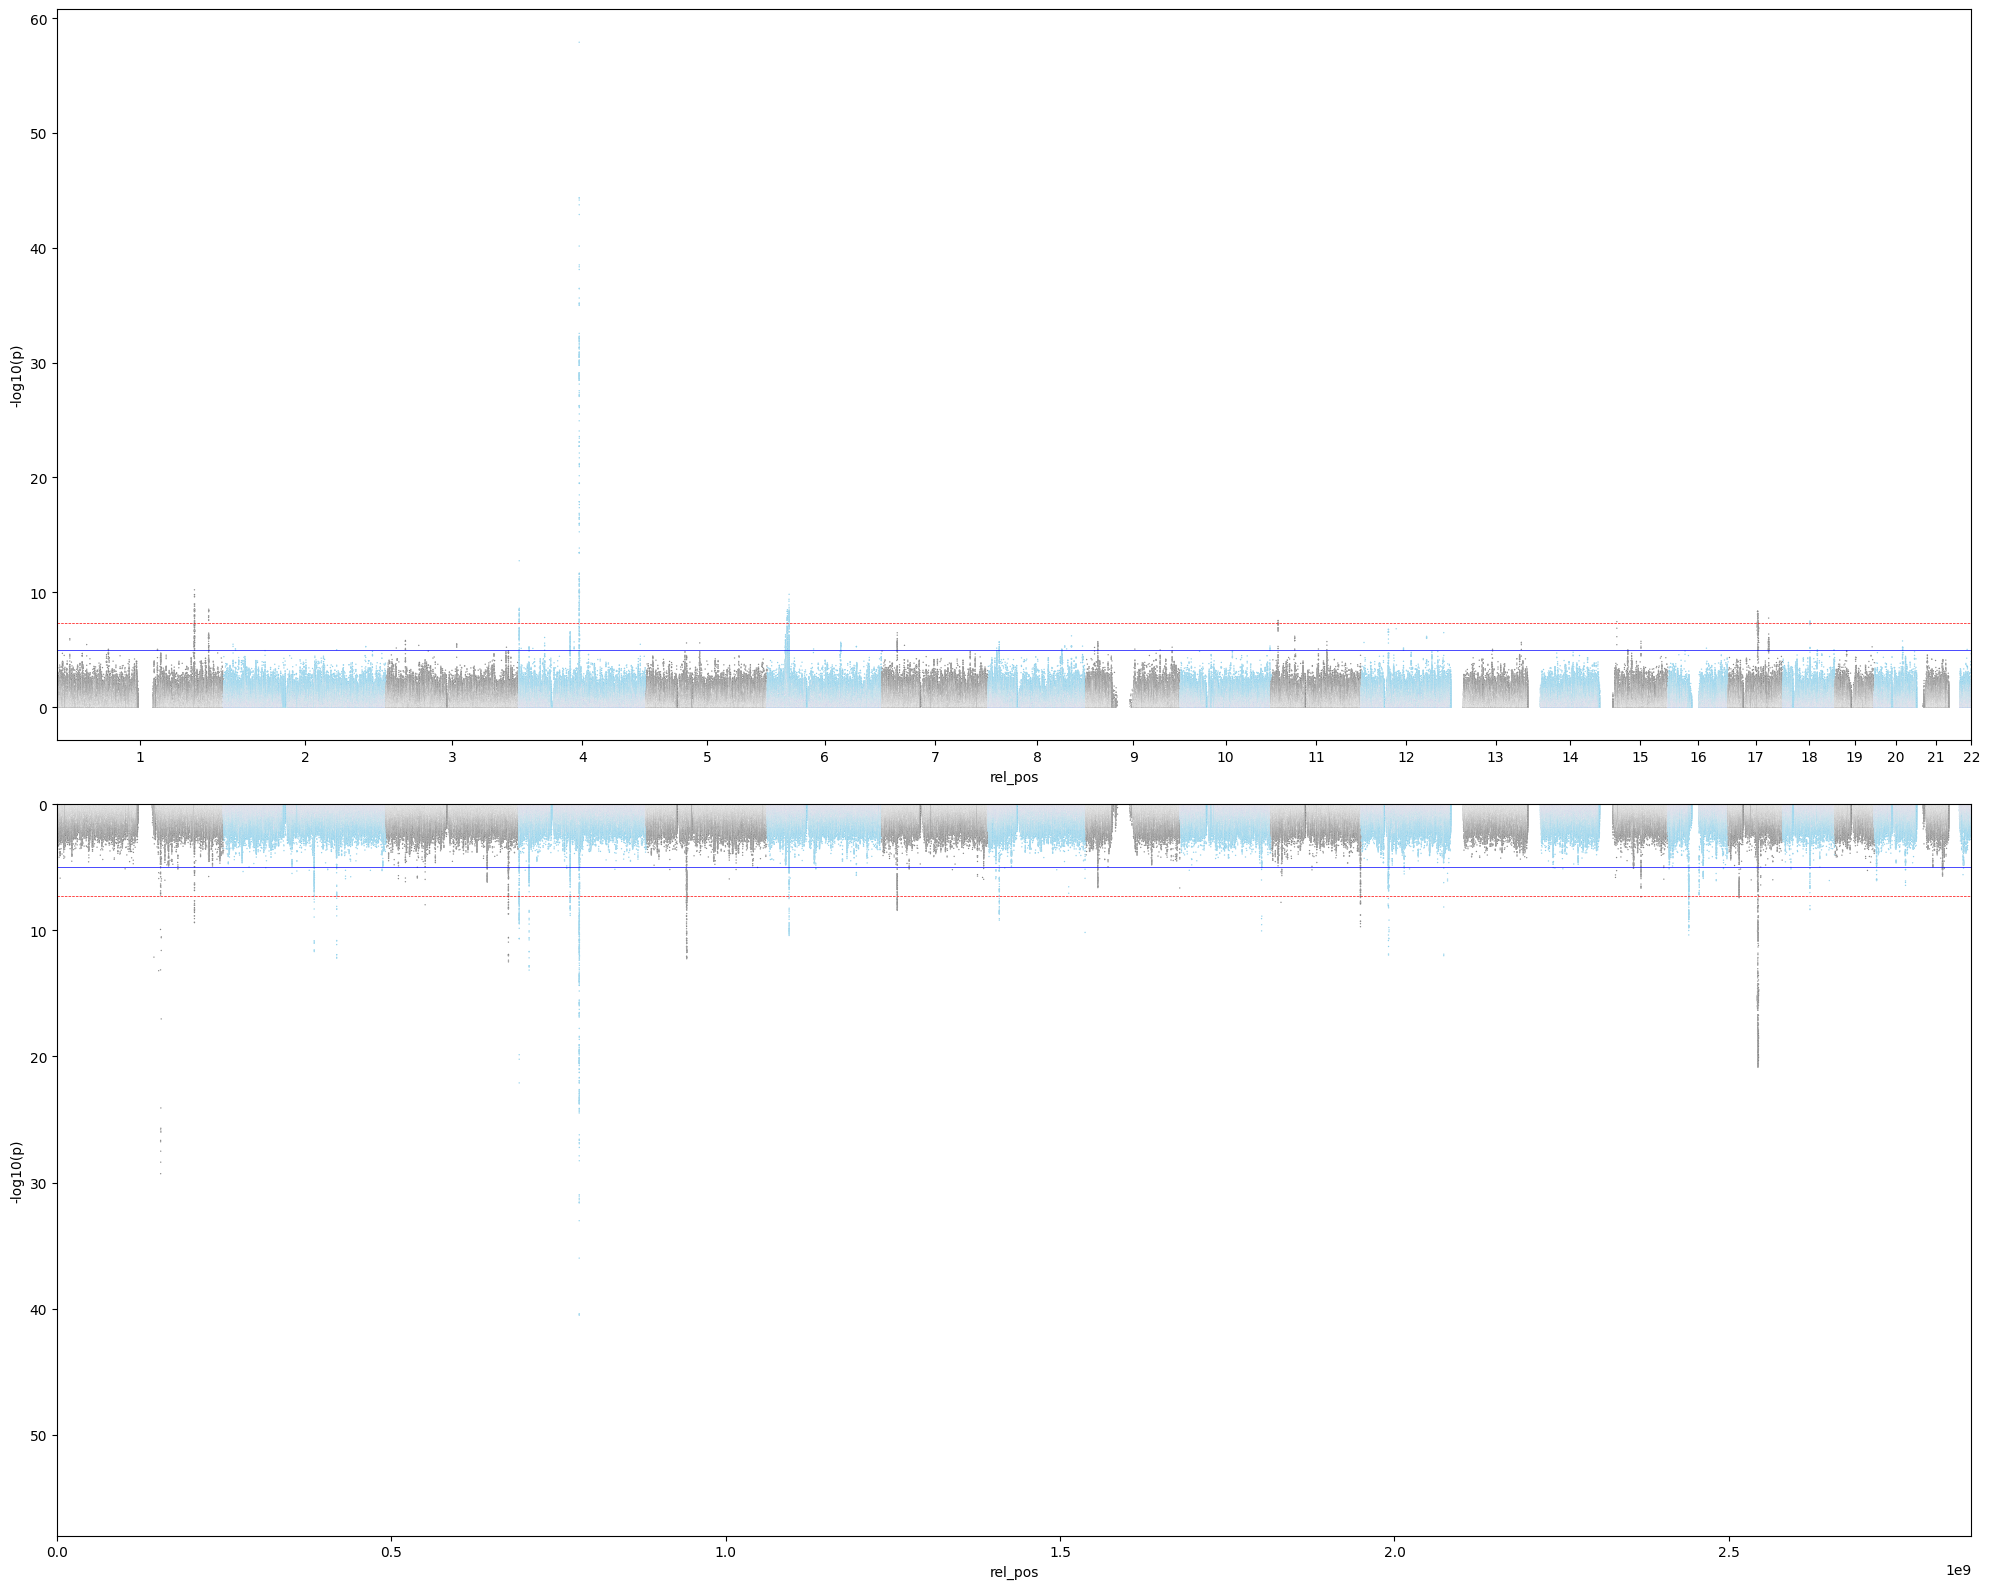

In [18]:
ggmiami(data=m_data, split_by='split_by', split_at='top', chr_col='CHR', pos_col='bp', p_col='p',)

In [12]:
#some = plt.subplot(211)
#type(some)
#some.set_xticks(ticks=m_data['axis']['center'].tolist())

In [16]:
m_data['axis']["CHR"].astype(str).tolist()

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22']